<a href="https://colab.research.google.com/github/yyc0314/DQN_atari_breakout/blob/main/DQN_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/
!pip install atari-py==0.2.6
!pip install gym==0.21.0
!pip install gym[atari]

^C


命令語法不正確。
'unrar' 不是內部或外部命令、可執行的程式或批次檔。
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "C:\Users\ai\AppData\Local\Programs\Python\Python311\Lib\site-packages\atari_py\__init__.py", line 1, in <module>
    from .ale_python_interface import *
  File "C:\Users\ai\AppData\Local\Programs\Python\Python311\Lib\site-packages\atari_py\ale_python_interface.py", line 17, in <module>
    ale_lib = cdll.LoadLibrary(os.path.join(os.path.dirname(__file__),
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ai\AppData\Local\Programs\Python\Python311\Lib\ctypes\__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ai\AppData\Local\Programs\Python\Python311\Lib\ctypes\__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
File

  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [1 lines of output]
  error in gym setup command: 'extras_require' must be a dictionary whose values are strings or lists of strings containing valid project/version requirement specifiers.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

Getting requirements to build wheel did not run successfully.
exit code: 1

See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


  Using cached gym-0.21.0.tar.gz (1.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Using cached gym-0.26.2-py3-none-any.whl
  Using cached gym_notices-0.0.8-py3-none-any.whl.metadata (1.0 kB)
Using cached gym_notices-0.0.8-py3-none-any.whl (3.0 kB)


--2024-04-24 11:43:20--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 212.83.163.6
Connecting to www.atarimania.com (www.atarimania.com)|212.83.163.6|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.atarimania.com/roms/Roms.rar [following]
--2024-04-24 11:43:21--  https://www.atarimania.com/roms/Roms.rar
Connecting to www.atarimania.com (www.atarimania.com)|212.83.163.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19612325 (19M) [application/octet-stream]
Saving to: 'Roms.rar.1'

     0K .......... .......... .......... .......... ..........  0% 83.0K 3m50s
    50K .......... .......... .......... .......... ..........  0% 78.9M 1m55s
   100K .......... .......... .......... .......... ..........  0%  166K 1m54s
   150K .......... .......... .......... .......... ..........  1% 70.0M 86s
   200K .......... .......... .......... .......... ..........  1%  173

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

##一般RL的運作方式

```
state=env.reset() #初始化
while True:
  action=choose_action(state) #RL演算法
  state_next,reward,done,infor=env.step(action) #done->是否結束 info->除了state以外的其他資訊
  env.render() #有些遊戲可以將畫面渲染出來
  state=state_next.copy() 更新狀態
  if done:
    break
```



In [ ]:
env_name = "ALE/Breakout-v5"
env = gym.make(env_name)

1
0.0 False False {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


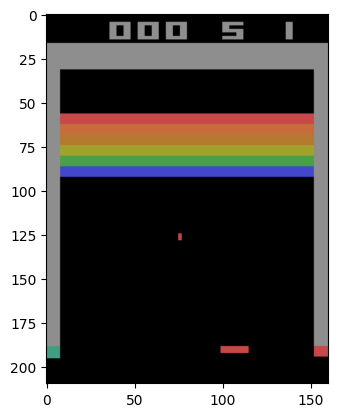

In [ ]:
'''print("environment:", env_name)
print("action space:", env.action_space.n) #有幾個動作
print("action:", env.unwrapped.get_action_meanings()) #動作的意義
print("observation space:", env.observation_space.shape)
'''
state,_ = env.reset()
action = env.action_space.sample()
print(action)
state_next, reward,ter,tru,info = env.step(1)
print(reward, ter,tru, info)
plt.figure()
plt.imshow(state_next)

In [ ]:
class BreakEnvWrapper(gym.Wrapper):
  def __init__(self,env,k,img_size=(84,84)):
    gym.Wrapper.__init__(self,env)
    self.k=k
    self.img_size=img_size
    obs_shape=env.observation_space.shape
    self.observation_space=gym.spaces.Box(low=0.0,high=1.0,shape=(k,img_size[0],img_size[1]),dtype=np.float32)

  def _preprocess(self,state,th=0.26):
    state=np.array(Image.fromarray(state).resize(self.img_size,Image.BILINEAR)) #resize
    state=state.astype(np.float64).mean(2)/255. #第三維(2 RGB)平均/255 轉灰階
    return state

  #疊加前後幀 動態上的變化
  def reset(self):
    state,_=self.env.reset()
    state=self._preprocess(state)
    state=state[np.newaxis,...].repeat(self.k,axis=0) #複製k份疊加
    return state

  #以防在k步期間遊戲就結束了
  def step(self,action):
    state_next=[]
    info=[]
    reward=0 #整個frame的大reward
    ter=False
    for i in range(self.k):
      if not ter:
        state_next_f,reward_f,ter_f,tru_f,info_f=self.env.step(action)
        state_next_f=self._preprocess(state_next_f)
        reward+=reward_f
        ter=ter_f
        info.append(info_f)
        #print("h1",type(state_next_f))
      state_next.append(state_next_f[np.newaxis,...])
    state_next=np.concatenate(state_next,0) #疊起來
    #print(type(state_next))

    return state_next,reward,ter,tru,info

observation space: (4, 84, 84)
(84, 84)


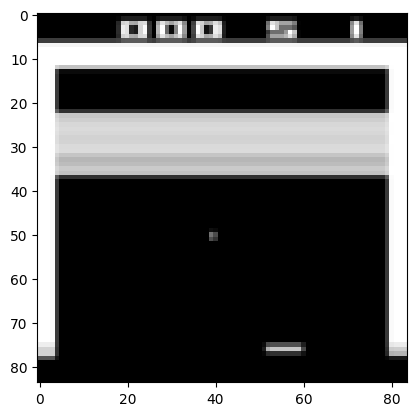

In [ ]:
env_break=BreakEnvWrapper(env,k=4,img_size=(84,84)) #k=4 -> 疊加4個frames
print("observation space:",env_break.observation_space.shape)

state=env_break.reset()
action=env_break.action_space.sample()
state_next, reward, ter,tru, info = env_break.step(1)
print(state_next[1].shape)
plt.imshow(state_next[0],cmap="gray")

In [ ]:
class QNet(nn.Module):
  def __init__(self,input_shape,n_actions):
    super(QNet,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(input_shape[0],32,kernel_size=8,stride=4),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=4,stride=2),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3,stride=1),
        nn.ReLU(),
    )
    conv_out_size=self._get_conv_out(input_shape)

    self.fc=nn.Sequential(
        nn.Flatten(),
        nn.Linear(conv_out_size,512),
        nn.ReLU(),
        nn.Linear(512,n_actions),

    )
  def _get_conv_out(self,shape):
    o=self.conv(torch.zeros(1,*shape))
    return int(np.prod(o.size())) #output的size算出最後一層conv的輸出大小

  def forward(self,x):
    conv_out=self.conv(x)
    out=self.fc(conv_out)
    return out

In [ ]:
date_old="50203"
date_new="50303"

In [ ]:
path_td="breakout/gif/png/tdloss_"+date_new+".png"
path_re="breakout/gif/png/rw_"+date_new+".png"
path_t_re="breakout/gif/png/t_rw_"+date_new+".png"

path_npy_old="breakout/gif/save/"+date_old #舊的(跟接著訓練的qnet同個檔名)
path_npy_new="breakout/gif/save/"+date_new #新的(此次訓練的檔名)

import os
if not os.path.exists(path_npy_new):
  os.makedirs(path_npy_new)

In [ ]:
class DeepQNetwork():
  def __init__(
    self,
    n_actions,
    input_shape,
    qnet,
    device,
    learning_rate = 2e-4,
    reward_decay = 0.99,
    replace_target_iter = 5000,
    memory_size = 200000, ###
    batch_size = 32,
  ):
    # initialize
    self.losses = [] #
    self.aver_l = [] #
    self.rewards = [] #
    self.aver_r = []  #
    self.t_r = [] #

    self.n_actions = n_actions
    self.input_shape = input_shape
    self.lr = learning_rate
    self.gamma = reward_decay
    self.replace_target_iter = replace_target_iter
    self.memory_size = memory_size
    self.batch_size = batch_size
    self.device = device
    self.learn_step_counter = 0
    self.init_memory()

    self.png_size=100000

    self.png_index= len(self.memory["aver_td"]) #

    self.qnet_eval=qnet(self.input_shape,self.n_actions).to(self.device)
    self.qnet_target=qnet(self.input_shape,self.n_actions).to(self.device)
    self.qnet_target.eval()
    self.optimizer=optim.RMSprop(self.qnet_eval.parameters(),lr=self.lr)

  def choose_action(self, state, epsilon=0):
    state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
    actions_value = self.qnet_eval.forward(state)
    if np.random.uniform(0,1) > epsilon:   # greedy
      action=torch.max(actions_value,1)[1].data.cpu().numpy()[0]
    else:   # random
      action=np.random.randint(0, self.n_actions)
    return action

  def learn(self): #根據我們的資料取一個batch來訓練
    if self.learn_step_counter % self.replace_target_iter==0: #特定步數後更新
      self.qnet_target.load_state_dict(self.qnet_eval.state_dict())

    if self.memory_counter > self.memory_size:
      sample_index=np.random.choice(self.memory_size,size=self.batch_size)
    else:
      sample_index=np.random.choice(self.memory_counter,size=self.batch_size)

    b_s = torch.FloatTensor(self.memory["s"][sample_index]).to(self.device)
    b_a = torch.LongTensor(self.memory["a"][sample_index]).to(self.device)
    b_r = torch.FloatTensor(self.memory["r"][sample_index]).to(self.device)
    b_s_ = torch.FloatTensor(self.memory["s_"][sample_index]).to(self.device)
    b_d = torch.FloatTensor(self.memory["done"][sample_index]).to(self.device)

    q_curr_eval = self.qnet_eval(b_s).gather(1,b_a)
    q_next_target = self.qnet_target(b_s_).detach()

    #next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN
    q_next_eval = self.qnet_eval(b_s_).detach()
    next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))   # DDQN
                #1-b_d if b_d==1(done)就沒有下一個值
    q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values

    self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)
    self.optimizer.zero_grad()
    self.loss.backward()
    self.optimizer.step()
    self.learn_step_counter += 1
    self.losses.append(self.loss.detach().cpu().numpy())

    return self.loss.detach().cpu().numpy()

  def init_memory(self): #初始化 replayed buffer
    if not hasattr(self, "memory"):
      self.memory={
        "s":np.zeros((self.memory_size,*self.input_shape)),
        "a":np.zeros((self.memory_size,1)),
        "r":np.zeros((self.memory_size,1)),
        "s_":np.zeros((self.memory_size,*self.input_shape)),
        "done":np.zeros((self.memory_size,1)),

        "aver_td":[],
        "aver_re":[],
        "total_re":[],
    }

  def store_transition(self,s,a,r,s_,d): #儲存進memory
    if not hasattr(self,"memory_counter"): #memory大小限制 初始化
      self.memory_counter=0
    if self.memory_counter <= self.memory_size: #當超過memory_size，重頭存
      index=self.memory_counter % self.memory_size
    else:
      index=np.random.randint(self.memory_size)

    self.memory["s"][index]=s
    self.memory["a"][index]=np.array(a).reshape(-1,1)
    self.memory["r"][index]=np.array(r).reshape(-1,1)
    self.memory["s_"][index]=s_
    self.memory["done"][index]=np.array(d).reshape(-1,1)
    self.memory_counter+=1

    self.rewards.append(r)

  def store_t_r(self,total_reward):
    self.t_r.append(total_reward)
    if self.t_r:
      self.memory["total_re"] = np.concatenate([self.memory["total_re"], [self.t_r[-1]]])


  def add_r_l(self):
    r_value=self.rewards[-100:]
    aver_rv=sum(r_value)/100
    self.aver_r.append(aver_rv)

    l_value=self.losses[-100:]
    aver_lv=sum(l_value)/100
    self.aver_l.append(aver_lv)

  def store_png(self): #100存一次averange
    if not hasattr(self,"png_memory_counter"): #memory大小限制
         self.png_memory_counter=0
    if self.png_memory_counter <= self.png_size: #當超過memory_size，重頭存
        self.png_index=self.png_memory_counter % self.png_size

    self.add_r_l()

    if(self.png_index>self.png_memory_counter):
        self.memory["aver_td"] = []
        self.memory["aver_re"] = []
        self.png_index = self.png_index % self.png_memory_counter

    if self.aver_l:
        self.memory["aver_td"] = np.concatenate([self.memory["aver_td"], [self.aver_l[-1]]])
    if self.aver_r:
        self.memory["aver_re"] = np.concatenate([self.memory["aver_re"], [self.aver_r[-1]]])

    self.png_index+=1

  def save_load_model(self, op, path="save", fname="qnet.pt"):
    import os
    if not os.path.exists(path):
        os.makedirs(path)
    file_path = os.path.join(path, fname)
    if op == "save":
        torch.save(self.qnet_eval.state_dict(), file_path)
        np.save(os.path.join(path_npy_new, "aver_td_"+date_new+".npy"), self.memory["aver_td"])
        np.save(os.path.join(path_npy_new, "aver_re_"+date_new+".npy"), self.memory["aver_re"])
        np.save(os.path.join(path_npy_new, "total_re_"+date_new+".npy"), self.memory["total_re"])

    elif op == "load":
        self.qnet_eval.load_state_dict(torch.load(file_path, map_location=self.device))
        self.qnet_target.load_state_dict(torch.load(file_path, map_location=self.device))
        aver_td_path = os.path.join(path_npy_old, "aver_td_"+date_old+".npy")
        aver_re_path = os.path.join(path_npy_old, "aver_re_"+date_old+".npy")
        total_re_path = os.path.join(path_npy_old, "total_re_"+date_old+".npy")
        if os.path.exists(aver_td_path):
            self.memory["aver_td"] = np.load(aver_td_path)
        if os.path.exists(aver_re_path):
            self.memory["aver_re"] = np.load(aver_re_path)
        if os.path.exists(total_re_path):
            self.memory["total_re"] = np.load(total_re_path)

  def plot_loss(self):
    x_loss=np.array(list(range(len(self.memory["aver_td"]))))
    plt.plot(x_loss,self.memory["aver_td"], label='TD Loss') ##
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('TD Loss over Training')
    plt.legend()
    plt.savefig(path_td)
    plt.show()

  def plot_rewards(self):
    x_reward=np.array(list(range(len(self.memory["aver_re"]))))
    plt.plot(x_reward,self.memory["aver_re"], label='Average Reward')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Episodes')
    plt.legend()
    plt.savefig(path_re)
    plt.show()

  def plot_t_r(self):
    x_t_reward=np.array(list(range(len(self.memory["total_re"]))))
    plt.plot(x_t_reward,self.memory["total_re"], label='Score')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Score over Episodes')
    plt.legend()
    plt.savefig(path_t_re)
    plt.show()



```
q_curr_eval = self.qnet_eval(b_s).gather(1,b_a)
q_next_target = self.qnet_target(b_s_).detach()

#next_state_values = q_next_target.max(1)[0].view(-1, 1)   # DQN
q_next_eval = self.qnet_eval(b_s_).detach()
next_state_values = q_next_target.gather(1, q_next_eval.max(1)[1].unsqueeze(1))   # DDQN
            #1-b_d if b_d==1(done)就沒有下一個值
q_curr_recur = b_r + (1-b_d) * self.gamma * next_state_values
```



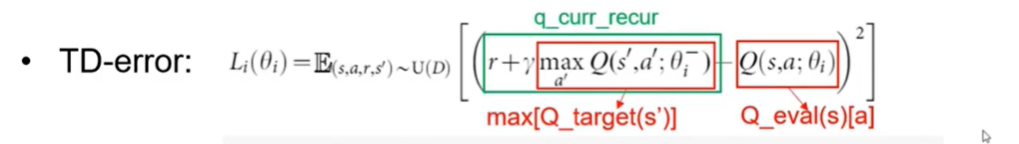



```
self.loss = F.smooth_l1_loss(q_curr_eval, q_curr_recur)
```



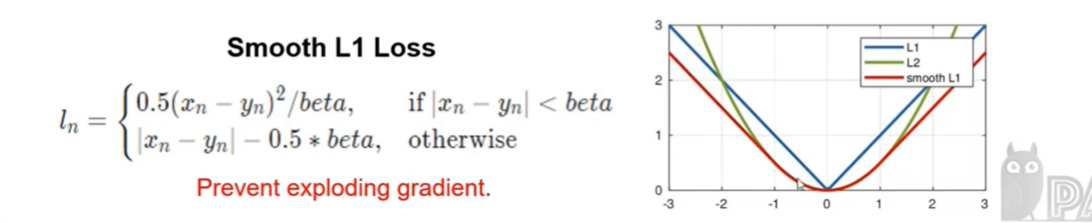

In [ ]:
stack_frames = 4
img_size = (84,84)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

agent = DeepQNetwork(
    n_actions = env.action_space.n,
    input_shape = [stack_frames, *img_size],
    qnet = QNet,
    device = device,
    learning_rate = 2e-4,
    reward_decay = 0.99,
    replace_target_iter = 5000,
    memory_size = 200000,
    batch_size = 32,
    )
print(agent.n_actions)
print(agent.qnet_eval)

4
QNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


#load!

In [ ]:
agent.save_load_model(op="load", path="breakout/gif/save", fname="qnet_50203.pt") #3.

#繼續

In [ ]:
def play(env, agent, stack_frames, img_size):
  # Reset environment.
  state = env.reset()
  img_buffer = [Image.fromarray(state[0]*255)]

  # Initialize information.
  step = 0
  total_reward = 0
  live_now=5

  # One episode.
  while True:
      # Select action.
      if step==0:
        action=1
      else:
        action = agent.choose_action(state)

      # Get next stacked state.
      state_next, reward, ter,tru, info = env.step(action)
      live_num=info[0].get("lives")

      if(live_num!=live_now):
        action=1
        state_next, reward, ter,tru, info = env.step(action)
        live_now=live_num

      if step % 2 == 0:
          img_buffer.append(Image.fromarray(state_next[0]*255))

      state = state_next.copy()
      step += 1
      total_reward += reward
      print('\rStep: {:3d} | Reward: {:.3f} / {:.3f}'\
          .format(step, reward, total_reward), end="")

      if ter or step>40000: ###改次數
          print()
          break

  return img_buffer


In [ ]:
import os
def save_gif(img_buffer, fname, gif_path=os.path.join("breakout/gif/train", "train"+date_new)): #1.
  if not os.path.exists(gif_path):
      os.makedirs(gif_path)
  img_buffer[0].save(os.path.join(gif_path, fname), save_all=True, append_images=img_buffer[1:], duration=1, loop=0)

In [ ]:
# Test Code
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, fname="test_"+date_new+".gif") #1.

Step: 196 | Reward: 0.000 / 23.000


In [ ]:
def epsilon_compute(frame_id, epsilon_max=1, epsilon_min=0.1, epsilon_decay=1000000): ##
  return epsilon_min + (epsilon_max - epsilon_min) * np.exp(-frame_id / epsilon_decay)

'\n    exploration -> 探索 -> 隨機採取random action、但有可能無法收斂\n    exploitation -> 開發 -> 收斂到best action、但有可能就只收斂到local minimum\n\n    解決方法:ɛ-Greedy -> 以某個值去決定做exploration還是exploitation\n    0-1中一開始設ɛ=1,先exploration,後調整ɛ越接近0做exploitation\n'

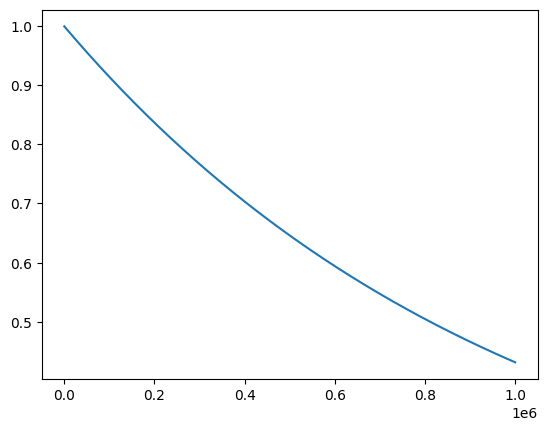

In [ ]:
frame_ids = np.array(range(1000000))
epsilons = epsilon_compute(frame_ids)
plt.plot(epsilons)
#epsilon curve
"""
    exploration -> 探索 -> 隨機採取random action、但有可能無法收斂
    exploitation -> 開發 -> 收斂到best action、但有可能就只收斂到local minimum

    解決方法:ɛ-Greedy -> 以某個值去決定做exploration還是exploitation
    0-1中一開始設ɛ=1,先exploration,後調整ɛ越接近0做exploitation
"""

In [ ]:
num=0

In [ ]:
def train(env, agent, stack_frames, img_size, save_path="save", max_steps=0):#4.
  total_step =  0
  episode = 0
  max_total_reward=0
  max_score=0

  while True:
    # Reset environment.
    state = env.reset()

    # Initialize information.
    step = 0
    total_reward = 0
    loss = 0
    live_now=5 ###
    max_reward=2
    score=0

    # One episode.
    while True:
      # TODO(Lab-6): Select action.
      epsilon = epsilon_compute(total_step)
      action = agent.choose_action(state, epsilon)
      # Get next stacked state.
      state_next, reward, ter,tru, info = env.step(action)
      live_num=info[0].get("lives") ###

      score+=reward

      if max_reward<reward: ###
        max_reward=reward+1

      if(live_num!=live_now):
        action=1
        state_next, reward,ter,tru, info = env.step(action)
        live_now=live_num
        reward-=1 ###


      # TODO(Lab-7): Train RL model.
      agent.store_transition(state, action, reward, state_next, ter)
      if total_step > 4*agent.batch_size: #蒐集一定步數後才開始訓練
        loss = agent.learn()

      state = state_next.copy()
      step += 1
      total_step += 1
      total_reward += reward

      if total_step % 100 == 0:
          agent.store_png() ####
      if ter:
        agent.store_t_r(score)
        if total_reward>max_total_reward:
          max_total_reward=total_reward

      if ter:
        print('\rEpisode: {:3d} | Step: {:3d} / {:3d} | Reward: {:.3f} / {:.3f} | Loss: {:.3f} | Epsilon: {:.3f}'\
            .format(episode, step, total_step, reward, total_reward, loss, epsilon))
        print("score:",score)

      if total_step % 10000 == 0:
        num=total_step % 100000
        num//=10000
        print("\nSave Model ...")
        agent.save_load_model(op="save", path=os.path.join("breakout/gif/save"), fname="qnet_"+date_new+"_"+str(num)+".pt")
        print("Generate GIF ...")
        img_buffer = play(env, agent, stack_frames, img_size)
        save_gif(img_buffer, "train"+date_new+"_" + str(total_step).zfill(6) + ".gif")
        print("Done !!")
        print("max_score:",max_score)
        agent.plot_loss()
        agent.plot_t_r()


      if ter or step>2000:
        episode += 1
        break

    if max_score<score:
      max_score=score
      print("max_score:",max_score)

    if total_step > max_steps:
      break
  print("max_score:",max_score)

Episode:   0 | Step: 140 / 8900141 | Reward: -1.000 / 10.000 | Loss: 0.136 | Epsilon: 0.100
score: 15.0
max_score: 15.0
Episode:   1 | Step: 182 / 8900323 | Reward: 0.000 / 15.000 | Loss: 0.164 | Epsilon: 0.100
score: 19.0
max_score: 19.0
Episode:   2 | Step: 152 / 8900475 | Reward: -1.000 / 10.000 | Loss: 0.106 | Epsilon: 0.100
score: 15.0
Episode:   3 | Step: 186 / 8900661 | Reward: 0.000 / 16.000 | Loss: 0.045 | Epsilon: 0.100
score: 20.0
max_score: 20.0
Episode:   4 | Step: 148 / 8900809 | Reward: -1.000 / 11.000 | Loss: 0.050 | Epsilon: 0.100
score: 16.0
Episode:   5 | Step: 162 / 8900971 | Reward: -1.000 / 9.000 | Loss: 0.031 | Epsilon: 0.100
score: 14.0
Episode:   6 | Step: 161 / 8901132 | Reward: 0.000 / 12.000 | Loss: 0.031 | Epsilon: 0.100
score: 16.0
Episode:   7 | Step: 120 / 8901252 | Reward: 0.000 / 10.000 | Loss: 0.058 | Epsilon: 0.100
score: 14.0
Episode:   8 | Step:  97 / 8901349 | Reward: 0.000 / 4.000 | Loss: 0.068 | Epsilon: 0.100
score: 8.0
Episode:   9 | Step: 125

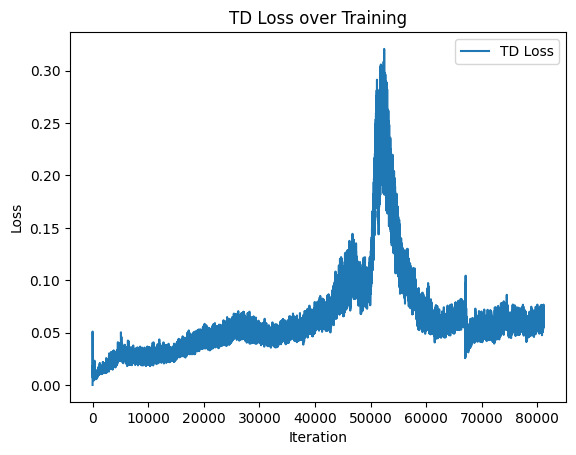

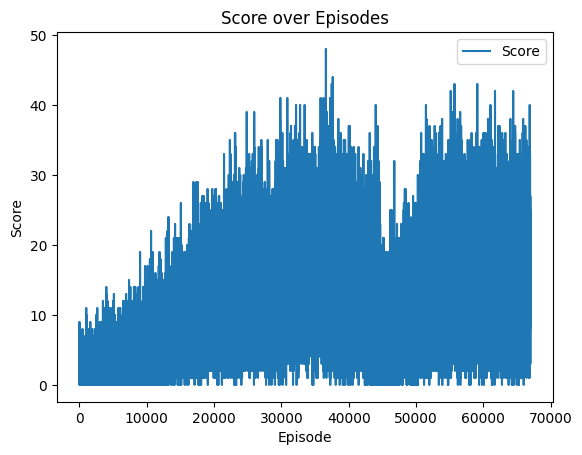

Episode:  65 | Step:  16 / 8910001 | Reward: -1.000 / 0.000 | Loss: 0.062 | Epsilon: 0.100
score: 1.0
Episode:  66 | Step: 185 / 8910186 | Reward: -1.000 / 18.000 | Loss: 0.101 | Epsilon: 0.100
score: 23.0
Episode:  67 | Step: 163 / 8910349 | Reward: 0.000 / 12.000 | Loss: 0.031 | Epsilon: 0.100
score: 16.0
Episode:  68 | Step: 186 / 8910535 | Reward: -1.000 / 21.000 | Loss: 0.056 | Epsilon: 0.100
score: 26.0
Episode:  69 | Step: 194 / 8910729 | Reward: 0.000 / 16.000 | Loss: 0.082 | Epsilon: 0.100
score: 20.0
Episode:  70 | Step: 140 / 8910869 | Reward: 0.000 / 7.000 | Loss: 0.061 | Epsilon: 0.100
score: 11.0
Episode:  71 | Step: 151 / 8911020 | Reward: -1.000 / 13.000 | Loss: 0.028 | Epsilon: 0.100
score: 18.0
Episode:  72 | Step: 156 / 8911176 | Reward: 0.000 / 12.000 | Loss: 0.058 | Epsilon: 0.100
score: 16.0
Episode:  73 | Step: 218 / 8911394 | Reward: 0.000 / 23.000 | Loss: 0.012 | Epsilon: 0.100
score: 27.0
Episode:  74 | Step: 120 / 8911514 | Reward: 0.000 / 12.000 | Loss: 0.01

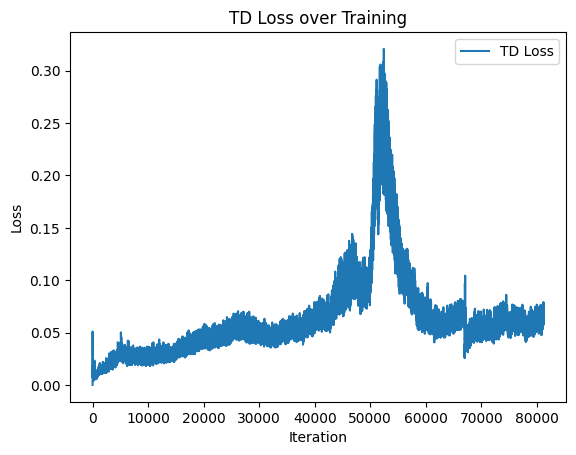

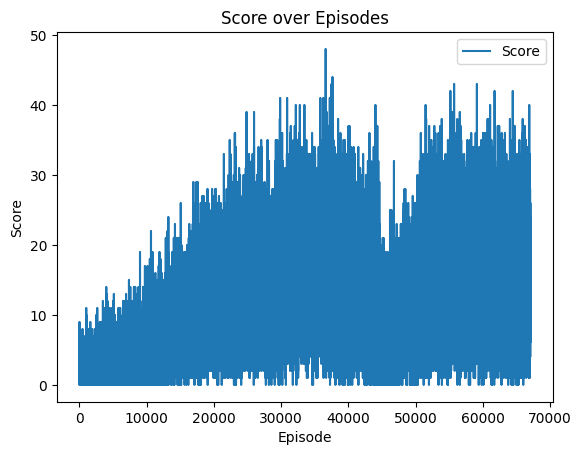

Episode: 131 | Step:  93 / 8920001 | Reward: -1.000 / 4.000 | Loss: 0.040 | Epsilon: 0.100
score: 7.0
Episode: 132 | Step: 175 / 8920176 | Reward: -1.000 / 18.000 | Loss: 0.033 | Epsilon: 0.100
score: 23.0
Episode: 133 | Step: 161 / 8920337 | Reward: -1.000 / 9.000 | Loss: 0.053 | Epsilon: 0.100
score: 14.0
Episode: 134 | Step: 182 / 8920519 | Reward: -1.000 / 15.000 | Loss: 0.079 | Epsilon: 0.100
score: 20.0
Episode: 135 | Step: 218 / 8920737 | Reward: 0.000 / 20.000 | Loss: 0.109 | Epsilon: 0.100
score: 24.0
Episode: 136 | Step: 147 / 8920884 | Reward: 0.000 / 11.000 | Loss: 0.109 | Epsilon: 0.100
score: 15.0
Episode: 137 | Step: 109 / 8920993 | Reward: 0.000 / 6.000 | Loss: 0.064 | Epsilon: 0.100
score: 10.0
Episode: 138 | Step: 200 / 8921193 | Reward: 0.000 / 17.000 | Loss: 0.023 | Epsilon: 0.100
score: 21.0
Episode: 139 | Step: 155 / 8921348 | Reward: 0.000 / 13.000 | Loss: 0.062 | Epsilon: 0.100
score: 17.0
Episode: 140 | Step: 107 / 8921455 | Reward: -1.000 / 4.000 | Loss: 0.058

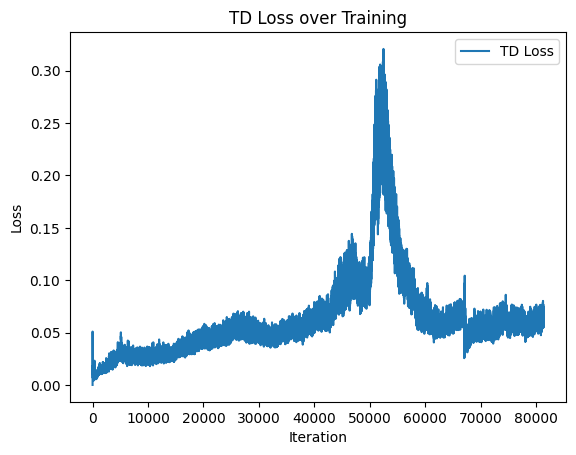

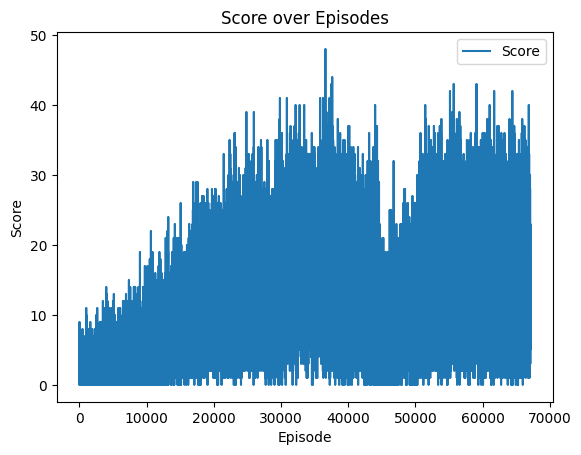

Episode: 200 | Step:  91 / 8930001 | Reward: -1.000 / 9.000 | Loss: 0.045 | Epsilon: 0.100
score: 11.0
Episode: 201 | Step: 137 / 8930138 | Reward: -1.000 / 5.000 | Loss: 0.053 | Epsilon: 0.100
score: 10.0
Episode: 202 | Step: 161 / 8930299 | Reward: 0.000 / 16.000 | Loss: 0.115 | Epsilon: 0.100
score: 20.0
Episode: 203 | Step:  60 / 8930359 | Reward: -1.000 / -2.000 | Loss: 0.142 | Epsilon: 0.100
score: 3.0
Episode: 204 | Step: 148 / 8930507 | Reward: 0.000 / 11.000 | Loss: 0.051 | Epsilon: 0.100
score: 15.0
Episode: 205 | Step: 164 / 8930671 | Reward: 0.000 / 16.000 | Loss: 0.046 | Epsilon: 0.100
score: 20.0
Episode: 206 | Step: 143 / 8930814 | Reward: 0.000 / 7.000 | Loss: 0.051 | Epsilon: 0.100
score: 11.0
Episode: 207 | Step:  89 / 8930903 | Reward: -1.000 / 2.000 | Loss: 0.116 | Epsilon: 0.100
score: 7.0
Episode: 208 | Step: 125 / 8931028 | Reward: 0.000 / 5.000 | Loss: 0.036 | Epsilon: 0.100
score: 9.0
Episode: 209 | Step: 168 / 8931196 | Reward: 0.000 / 23.000 | Loss: 0.016 | E

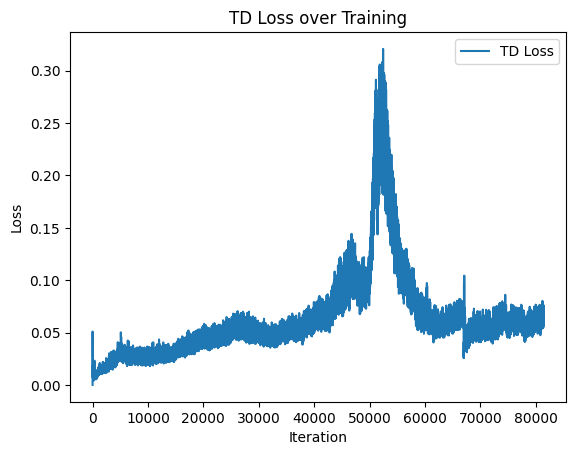

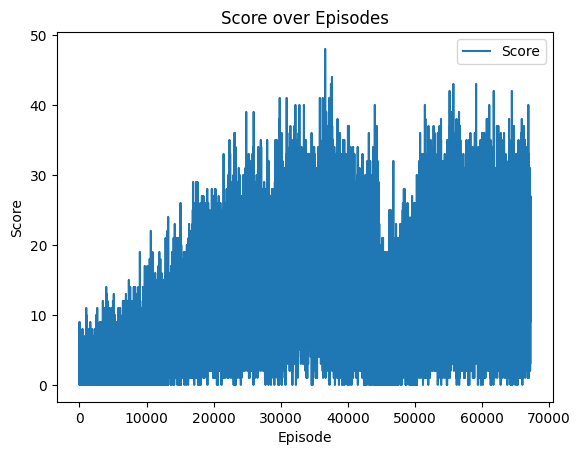

Episode: 268 | Step:  45 / 8940001 | Reward: -1.000 / 0.000 | Loss: 0.055 | Epsilon: 0.100
score: 3.0
Episode: 269 | Step: 134 / 8940135 | Reward: 0.000 / 9.000 | Loss: 0.046 | Epsilon: 0.100
score: 13.0
Episode: 270 | Step: 180 / 8940315 | Reward: 0.000 / 12.000 | Loss: 0.055 | Epsilon: 0.100
score: 16.0
Episode: 271 | Step: 191 / 8940506 | Reward: 0.000 / 13.000 | Loss: 0.078 | Epsilon: 0.100
score: 17.0
Episode: 272 | Step: 166 / 8940672 | Reward: 0.000 / 14.000 | Loss: 0.109 | Epsilon: 0.100
score: 18.0
Episode: 273 | Step: 167 / 8940839 | Reward: 0.000 / 10.000 | Loss: 0.045 | Epsilon: 0.100
score: 14.0
Episode: 274 | Step: 162 / 8941001 | Reward: 0.000 / 13.000 | Loss: 0.085 | Epsilon: 0.100
score: 17.0
Episode: 275 | Step: 184 / 8941185 | Reward: -1.000 / 15.000 | Loss: 0.061 | Epsilon: 0.100
score: 20.0
Episode: 276 | Step: 201 / 8941386 | Reward: 0.000 / 24.000 | Loss: 0.085 | Epsilon: 0.100
score: 28.0
Episode: 277 | Step: 183 / 8941569 | Reward: 0.000 / 21.000 | Loss: 0.058 

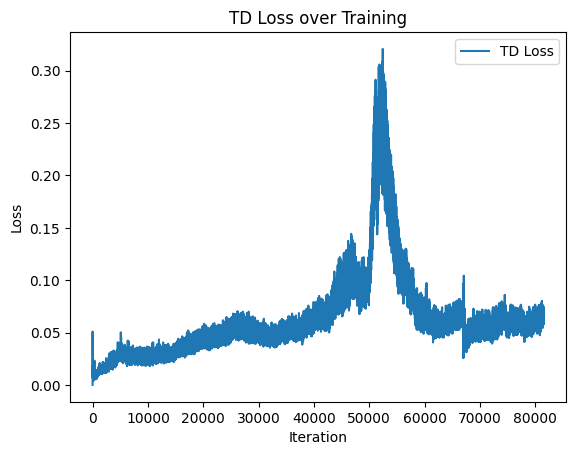

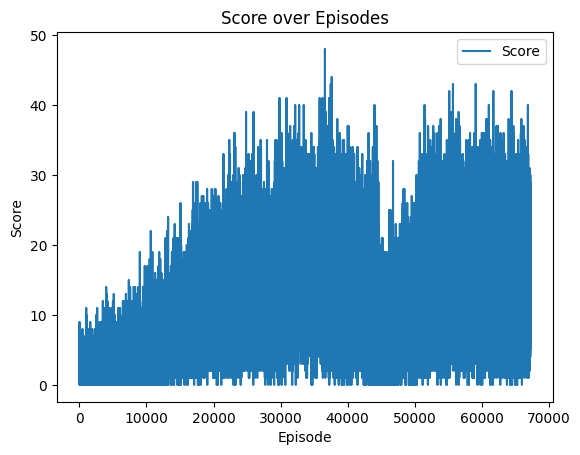

Episode: 333 | Step:   8 / 8950001 | Reward: -1.000 / -1.000 | Loss: 0.058 | Epsilon: 0.100
score: 0.0
Episode: 334 | Step: 158 / 8950159 | Reward: 0.000 / 10.000 | Loss: 0.087 | Epsilon: 0.100
score: 14.0
Episode: 335 | Step: 167 / 8950326 | Reward: 0.000 / 7.000 | Loss: 0.148 | Epsilon: 0.100
score: 11.0
Episode: 336 | Step: 161 / 8950487 | Reward: -1.000 / 7.000 | Loss: 0.068 | Epsilon: 0.100
score: 12.0
Episode: 337 | Step: 170 / 8950657 | Reward: 0.000 / 13.000 | Loss: 0.083 | Epsilon: 0.100
score: 17.0
Episode: 338 | Step: 127 / 8950784 | Reward: 0.000 / 11.000 | Loss: 0.090 | Epsilon: 0.100
score: 15.0
Episode: 339 | Step: 172 / 8950956 | Reward: 0.000 / 4.000 | Loss: 0.095 | Epsilon: 0.100
score: 8.0
Episode: 340 | Step:  68 / 8951024 | Reward: -1.000 / -2.000 | Loss: 0.061 | Epsilon: 0.100
score: 3.0
Episode: 341 | Step: 197 / 8951221 | Reward: 0.000 / 12.000 | Loss: 0.112 | Epsilon: 0.100
score: 16.0
Episode: 342 | Step: 158 / 8951379 | Reward: -1.000 / 18.000 | Loss: 0.049 |

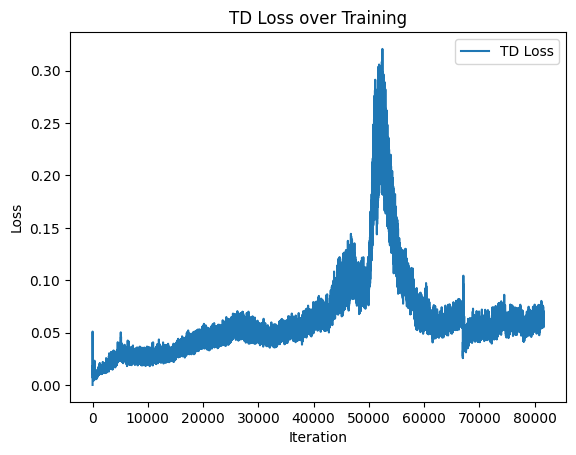

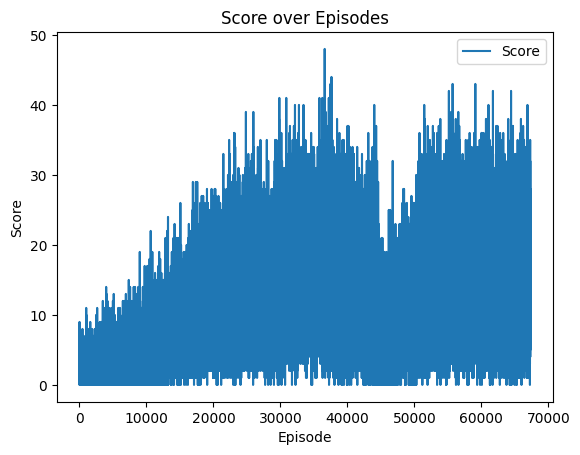

Episode: 398 | Step:  65 / 8960001 | Reward: -1.000 / -1.000 | Loss: 0.054 | Epsilon: 0.100
score: 0.0
Episode: 399 | Step: 233 / 8960234 | Reward: 0.000 / 8.000 | Loss: 0.039 | Epsilon: 0.100
score: 12.0
Episode: 400 | Step: 150 / 8960384 | Reward: -1.000 / 4.000 | Loss: 0.045 | Epsilon: 0.100
score: 9.0
Episode: 401 | Step: 117 / 8960501 | Reward: -1.000 / 3.000 | Loss: 0.025 | Epsilon: 0.100
score: 8.0
Episode: 402 | Step: 102 / 8960603 | Reward: 0.000 / 3.000 | Loss: 0.072 | Epsilon: 0.100
score: 7.0
Episode: 403 | Step: 155 / 8960758 | Reward: -1.000 / 10.000 | Loss: 0.056 | Epsilon: 0.100
score: 15.0
Episode: 404 | Step: 198 / 8960956 | Reward: 0.000 / 23.000 | Loss: 0.020 | Epsilon: 0.100
score: 27.0
Episode: 405 | Step: 181 / 8961137 | Reward: -1.000 / 11.000 | Loss: 0.055 | Epsilon: 0.100
score: 16.0
Episode: 406 | Step: 193 / 8961330 | Reward: 0.000 / 13.000 | Loss: 0.021 | Epsilon: 0.100
score: 17.0
Episode: 407 | Step: 143 / 8961473 | Reward: -1.000 / 3.000 | Loss: 0.022 | 

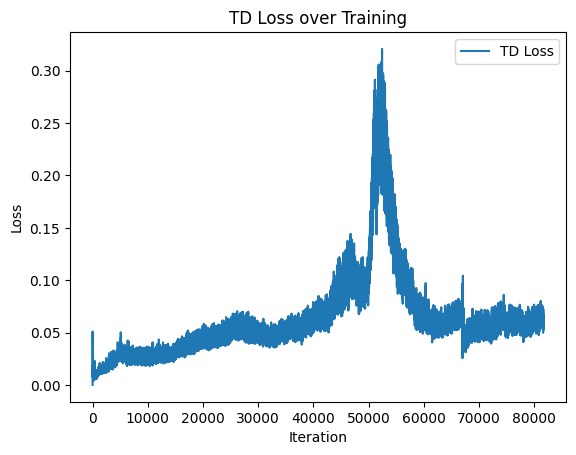

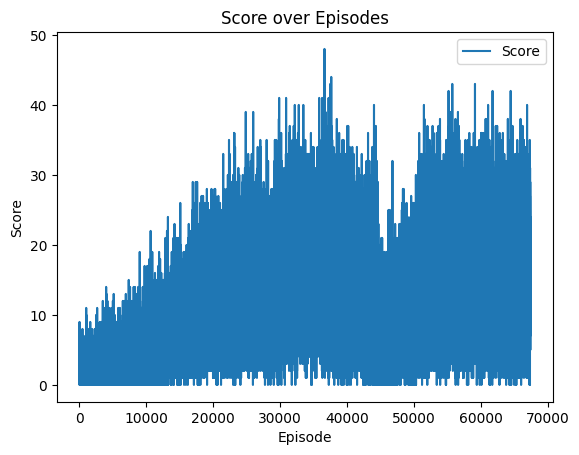

Episode: 457 | Step:  49 / 8970001 | Reward: -1.000 / 1.000 | Loss: 0.029 | Epsilon: 0.100
score: 2.0
Episode: 458 | Step:  90 / 8970091 | Reward: -1.000 / 1.000 | Loss: 0.088 | Epsilon: 0.100
score: 6.0
Episode: 459 | Step: 203 / 8970294 | Reward: 0.000 / 14.000 | Loss: 0.039 | Epsilon: 0.100
score: 18.0
Episode: 460 | Step: 204 / 8970498 | Reward: -1.000 / 23.000 | Loss: 0.078 | Epsilon: 0.100
score: 28.0
Episode: 461 | Step: 214 / 8970712 | Reward: -1.000 / 23.000 | Loss: 0.025 | Epsilon: 0.100
score: 28.0
Episode: 462 | Step: 204 / 8970916 | Reward: 0.000 / 13.000 | Loss: 0.048 | Epsilon: 0.100
score: 17.0
Episode: 463 | Step: 148 / 8971064 | Reward: 0.000 / 13.000 | Loss: 0.023 | Epsilon: 0.100
score: 17.0
Episode: 464 | Step: 146 / 8971210 | Reward: 0.000 / 13.000 | Loss: 0.045 | Epsilon: 0.100
score: 17.0
Episode: 465 | Step: 161 / 8971371 | Reward: -1.000 / 11.000 | Loss: 0.037 | Epsilon: 0.100
score: 16.0
Episode: 466 | Step: 151 / 8971522 | Reward: -1.000 / 7.000 | Loss: 0.04

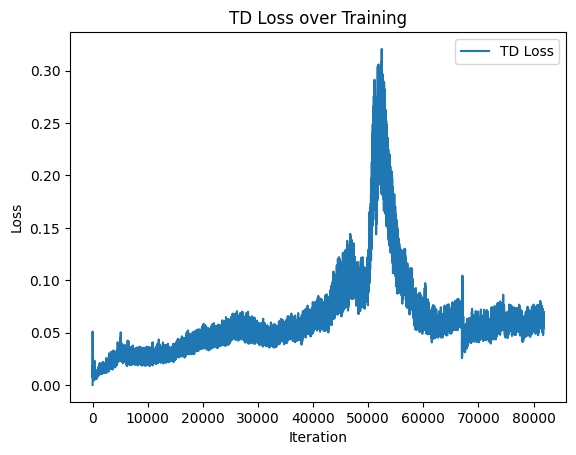

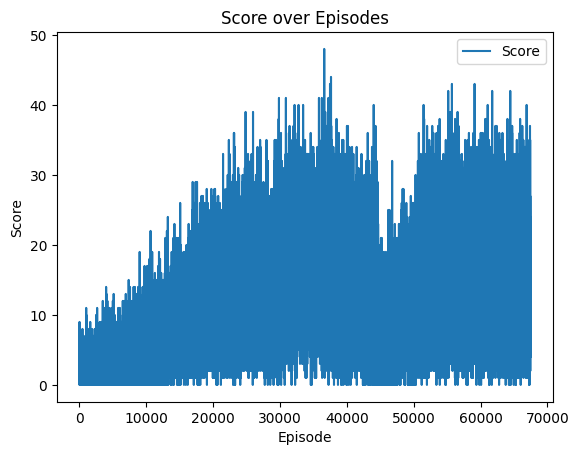

Episode: 523 | Step: 114 / 8980001 | Reward: -1.000 / 8.000 | Loss: 0.047 | Epsilon: 0.100
score: 11.0
Episode: 524 | Step: 140 / 8980141 | Reward: -1.000 / 6.000 | Loss: 0.076 | Epsilon: 0.100
score: 11.0
Episode: 525 | Step: 192 / 8980333 | Reward: 0.000 / 19.000 | Loss: 0.051 | Epsilon: 0.100
score: 23.0
Episode: 526 | Step: 146 / 8980479 | Reward: -1.000 / 10.000 | Loss: 0.105 | Epsilon: 0.100
score: 15.0
Episode: 527 | Step: 182 / 8980661 | Reward: 0.000 / 18.000 | Loss: 0.047 | Epsilon: 0.100
score: 22.0
Episode: 528 | Step: 135 / 8980796 | Reward: -1.000 / 5.000 | Loss: 0.026 | Epsilon: 0.100
score: 10.0
Episode: 529 | Step: 147 / 8980943 | Reward: -1.000 / 6.000 | Loss: 0.074 | Epsilon: 0.100
score: 11.0
Episode: 530 | Step: 143 / 8981086 | Reward: 0.000 / 15.000 | Loss: 0.021 | Epsilon: 0.100
score: 19.0
Episode: 531 | Step: 126 / 8981212 | Reward: -1.000 / 7.000 | Loss: 0.027 | Epsilon: 0.100
score: 12.0
Episode: 532 | Step: 137 / 8981349 | Reward: 0.000 / 6.000 | Loss: 0.041

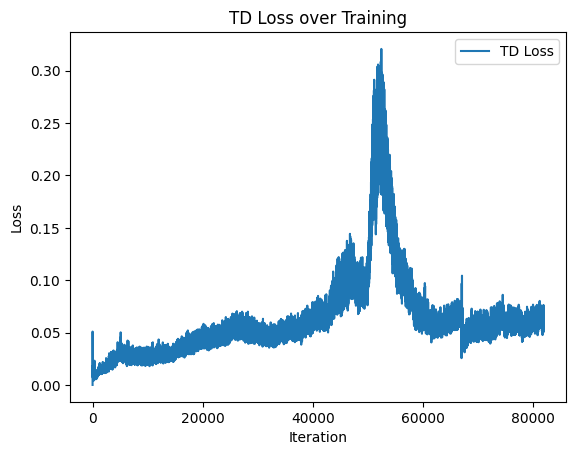

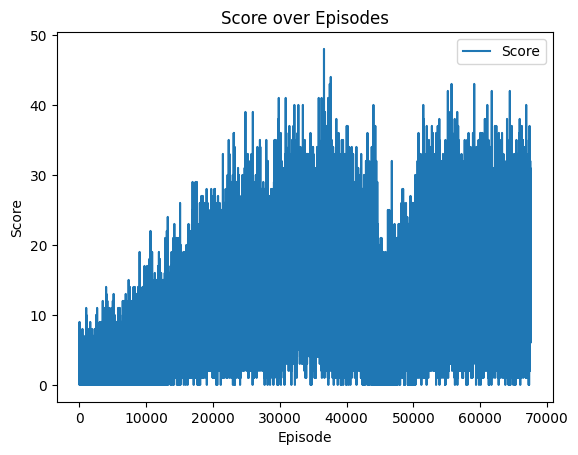

Episode: 588 | Step: 123 / 8990001 | Reward: -1.000 / 11.000 | Loss: 0.024 | Epsilon: 0.100
score: 15.0
Episode: 589 | Step: 157 / 8990158 | Reward: 0.000 / 10.000 | Loss: 0.094 | Epsilon: 0.100
score: 14.0
Episode: 590 | Step: 229 / 8990387 | Reward: 0.000 / 25.000 | Loss: 0.040 | Epsilon: 0.100
score: 29.0
Episode: 591 | Step: 157 / 8990544 | Reward: 0.000 / 12.000 | Loss: 0.089 | Epsilon: 0.100
score: 16.0
Episode: 592 | Step: 186 / 8990730 | Reward: 0.000 / 12.000 | Loss: 0.111 | Epsilon: 0.100
score: 16.0
Episode: 593 | Step: 157 / 8990887 | Reward: 0.000 / 18.000 | Loss: 0.077 | Epsilon: 0.100
score: 22.0
Episode: 594 | Step: 119 / 8991006 | Reward: 0.000 / 14.000 | Loss: 0.075 | Epsilon: 0.100
score: 18.0
Episode: 595 | Step: 210 / 8991216 | Reward: 0.000 / 20.000 | Loss: 0.010 | Epsilon: 0.100
score: 24.0
Episode: 596 | Step: 131 / 8991347 | Reward: -1.000 / 12.000 | Loss: 0.046 | Epsilon: 0.100
score: 17.0
Episode: 597 | Step: 156 / 8991503 | Reward: 0.000 / 17.000 | Loss: 0.0

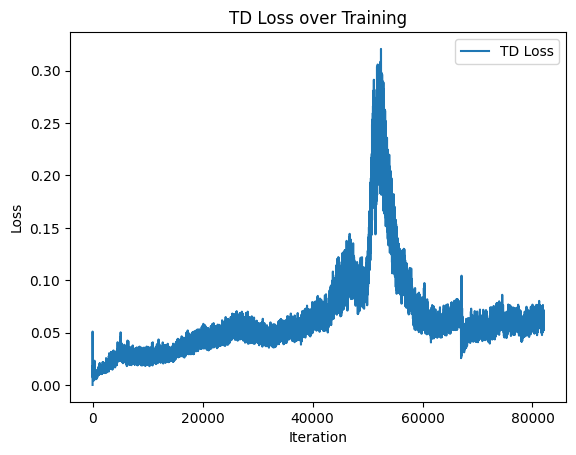

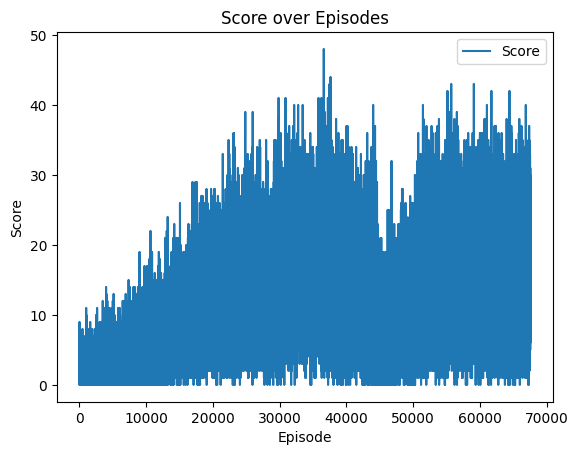

Episode: 650 | Step:  19 / 9000001 | Reward: -1.000 / -1.000 | Loss: 0.055 | Epsilon: 0.100
score: 0.0
Episode: 651 | Step: 139 / 9000140 | Reward: -1.000 / 4.000 | Loss: 0.092 | Epsilon: 0.100
score: 9.0
Episode: 652 | Step: 146 / 9000286 | Reward: 0.000 / 7.000 | Loss: 0.025 | Epsilon: 0.100
score: 11.0
Episode: 653 | Step: 175 / 9000461 | Reward: 0.000 / 12.000 | Loss: 0.095 | Epsilon: 0.100
score: 16.0
Episode: 654 | Step: 156 / 9000617 | Reward: 0.000 / 19.000 | Loss: 0.117 | Epsilon: 0.100
score: 23.0
Episode: 655 | Step: 152 / 9000769 | Reward: 0.000 / 5.000 | Loss: 0.046 | Epsilon: 0.100
score: 9.0
Episode: 656 | Step: 123 / 9000892 | Reward: 0.000 / 5.000 | Loss: 0.043 | Epsilon: 0.100
score: 9.0
Episode: 657 | Step: 163 / 9001055 | Reward: -1.000 / 6.000 | Loss: 0.025 | Epsilon: 0.100
score: 11.0
Episode: 658 | Step: 180 / 9001235 | Reward: -1.000 / 15.000 | Loss: 0.253 | Epsilon: 0.100
score: 20.0
Episode: 659 | Step: 163 / 9001398 | Reward: 0.000 / 8.000 | Loss: 0.071 | Eps

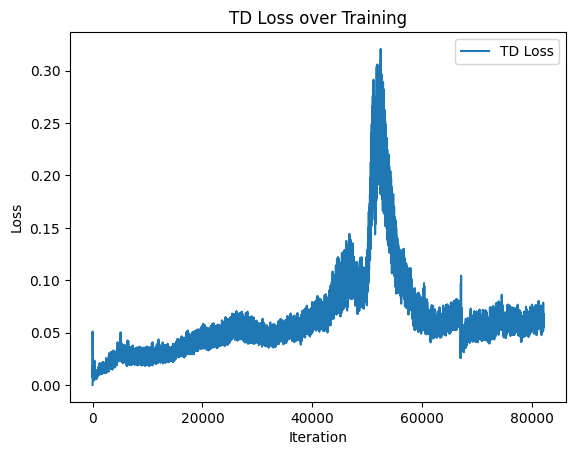

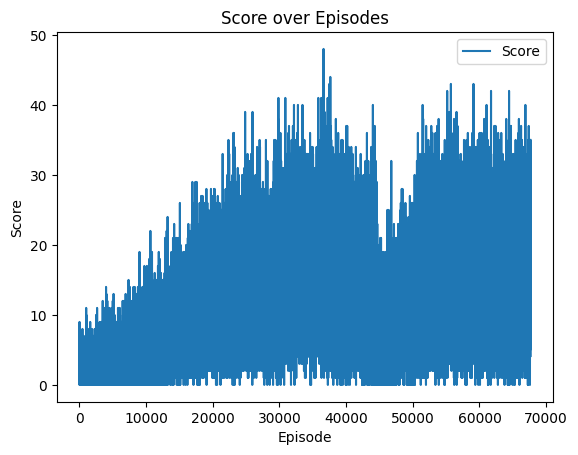

Episode: 711 | Step: 150 / 9010001 | Reward: -1.000 / 10.000 | Loss: 0.056 | Epsilon: 0.100
score: 15.0
Episode: 712 | Step: 210 / 9010211 | Reward: -1.000 / 18.000 | Loss: 0.061 | Epsilon: 0.100
score: 23.0
Episode: 713 | Step: 149 / 9010360 | Reward: 0.000 / 15.000 | Loss: 0.047 | Epsilon: 0.100
score: 19.0
Episode: 714 | Step: 148 / 9010508 | Reward: 0.000 / 8.000 | Loss: 0.019 | Epsilon: 0.100
score: 12.0
Episode: 715 | Step: 173 / 9010681 | Reward: 0.000 / 19.000 | Loss: 0.064 | Epsilon: 0.100
score: 23.0
Episode: 716 | Step: 134 / 9010815 | Reward: -1.000 / 12.000 | Loss: 0.042 | Epsilon: 0.100
score: 17.0
Episode: 717 | Step: 158 / 9010973 | Reward: 0.000 / 11.000 | Loss: 0.086 | Epsilon: 0.100
score: 15.0
Episode: 718 | Step: 197 / 9011170 | Reward: 0.000 / 20.000 | Loss: 0.094 | Epsilon: 0.100
score: 24.0
Episode: 719 | Step: 142 / 9011312 | Reward: 0.000 / 11.000 | Loss: 0.032 | Epsilon: 0.100
score: 15.0
Episode: 720 | Step: 191 / 9011503 | Reward: 0.000 / 9.000 | Loss: 0.13

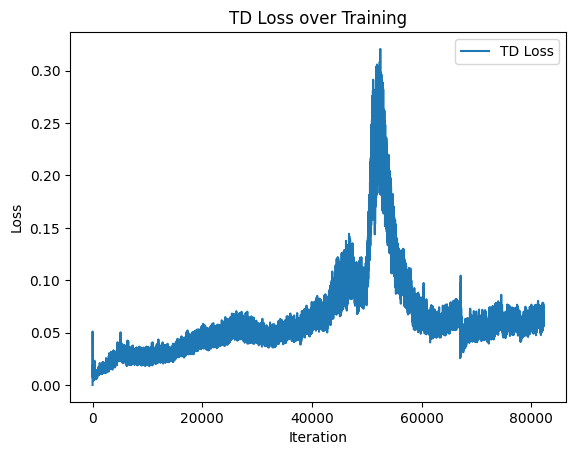

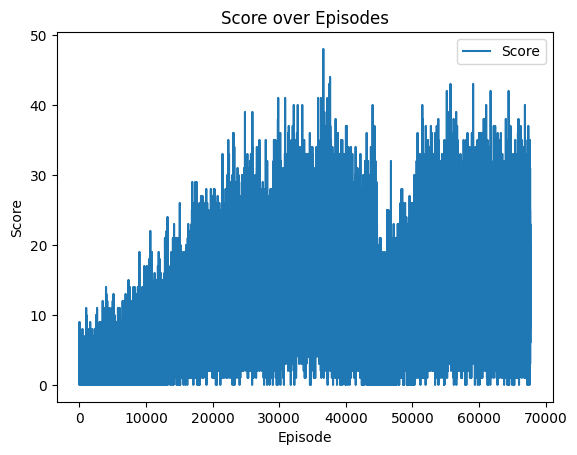

Episode: 778 | Step: 103 / 9020001 | Reward: -1.000 / 8.000 | Loss: 0.044 | Epsilon: 0.100
score: 10.0
Episode: 779 | Step: 150 / 9020151 | Reward: -1.000 / 16.000 | Loss: 0.064 | Epsilon: 0.100
score: 21.0
Episode: 780 | Step: 136 / 9020287 | Reward: 0.000 / 7.000 | Loss: 0.125 | Epsilon: 0.100
score: 11.0
Episode: 781 | Step: 142 / 9020429 | Reward: -1.000 / 9.000 | Loss: 0.035 | Epsilon: 0.100
score: 14.0
Episode: 782 | Step: 121 / 9020550 | Reward: 0.000 / 6.000 | Loss: 0.065 | Epsilon: 0.100
score: 10.0
Episode: 783 | Step: 156 / 9020706 | Reward: -1.000 / 7.000 | Loss: 0.023 | Epsilon: 0.100
score: 12.0
Episode: 784 | Step: 131 / 9020837 | Reward: 0.000 / 6.000 | Loss: 0.040 | Epsilon: 0.100
score: 10.0
Episode: 785 | Step: 151 / 9020988 | Reward: -1.000 / 8.000 | Loss: 0.023 | Epsilon: 0.100
score: 13.0
Episode: 786 | Step: 185 / 9021173 | Reward: 0.000 / 18.000 | Loss: 0.115 | Epsilon: 0.100
score: 22.0
Episode: 787 | Step: 142 / 9021315 | Reward: 0.000 / 10.000 | Loss: 0.133 |

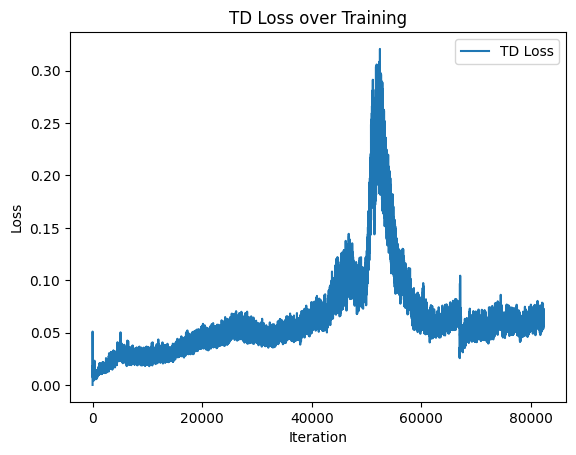

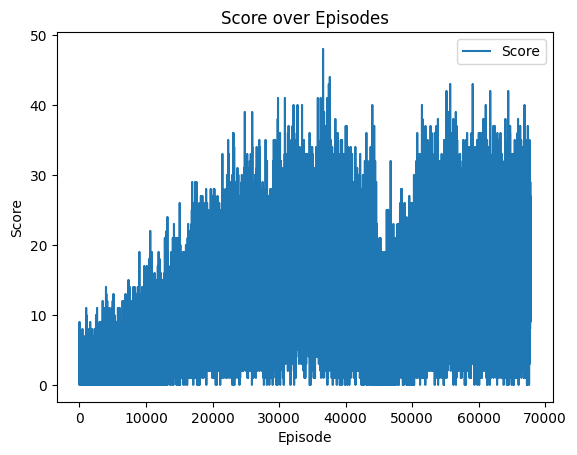

Episode: 844 | Step:  19 / 9030001 | Reward: -1.000 / 0.000 | Loss: 0.033 | Epsilon: 0.100
score: 1.0
Episode: 845 | Step: 137 / 9030138 | Reward: -1.000 / 5.000 | Loss: 0.130 | Epsilon: 0.100
score: 10.0
Episode: 846 | Step: 146 / 9030284 | Reward: 0.000 / 8.000 | Loss: 0.056 | Epsilon: 0.100
score: 12.0
Episode: 847 | Step: 160 / 9030444 | Reward: 0.000 / 17.000 | Loss: 0.044 | Epsilon: 0.100
score: 21.0
Episode: 848 | Step: 172 / 9030616 | Reward: 0.000 / 19.000 | Loss: 0.050 | Epsilon: 0.100
score: 23.0
Episode: 849 | Step: 176 / 9030792 | Reward: 0.000 / 20.000 | Loss: 0.049 | Epsilon: 0.100
score: 24.0
Episode: 850 | Step: 149 / 9030941 | Reward: -1.000 / 11.000 | Loss: 0.077 | Epsilon: 0.100
score: 16.0
Episode: 851 | Step:  42 / 9030983 | Reward: -1.000 / -4.000 | Loss: 0.137 | Epsilon: 0.100
score: 1.0
Episode: 852 | Step: 112 / 9031095 | Reward: -1.000 / 3.000 | Loss: 0.046 | Epsilon: 0.100
score: 8.0
Episode: 853 | Step: 161 / 9031256 | Reward: 0.000 / 13.000 | Loss: 0.039 |

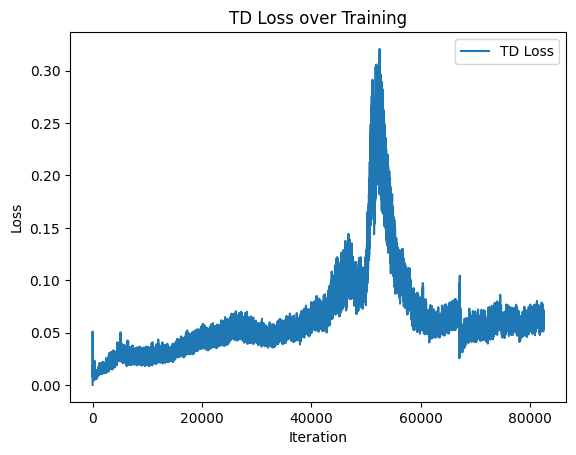

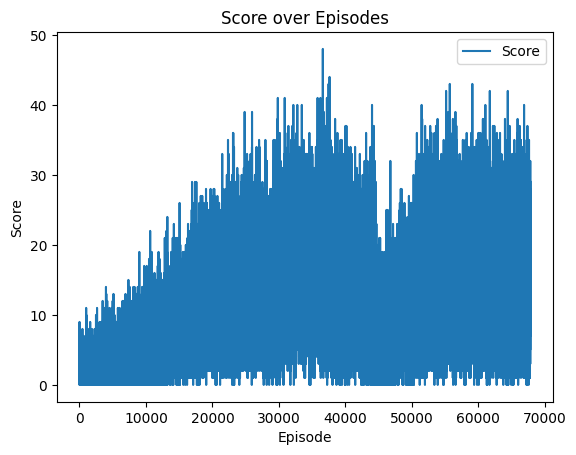

Episode: 912 | Step:  21 / 9040001 | Reward: -1.000 / -2.000 | Loss: 0.060 | Epsilon: 0.100
score: 0.0
Episode: 913 | Step: 228 / 9040229 | Reward: -1.000 / 6.000 | Loss: 0.083 | Epsilon: 0.100
score: 11.0
Episode: 914 | Step: 165 / 9040394 | Reward: -1.000 / 13.000 | Loss: 0.042 | Epsilon: 0.100
score: 18.0
Episode: 915 | Step: 194 / 9040588 | Reward: -1.000 / 19.000 | Loss: 0.104 | Epsilon: 0.100
score: 24.0
Episode: 916 | Step: 148 / 9040736 | Reward: 0.000 / 8.000 | Loss: 0.072 | Epsilon: 0.100
score: 12.0
Episode: 917 | Step: 232 / 9040968 | Reward: 0.000 / 30.000 | Loss: 0.030 | Epsilon: 0.100
score: 34.0
Episode: 918 | Step: 186 / 9041154 | Reward: 0.000 / 18.000 | Loss: 0.030 | Epsilon: 0.100
score: 22.0
Episode: 919 | Step: 190 / 9041344 | Reward: 0.000 / 13.000 | Loss: 0.046 | Epsilon: 0.100
score: 17.0
Episode: 920 | Step: 148 / 9041492 | Reward: 0.000 / 10.000 | Loss: 0.021 | Epsilon: 0.100
score: 14.0
Episode: 921 | Step: 121 / 9041613 | Reward: 0.000 / 6.000 | Loss: 0.035

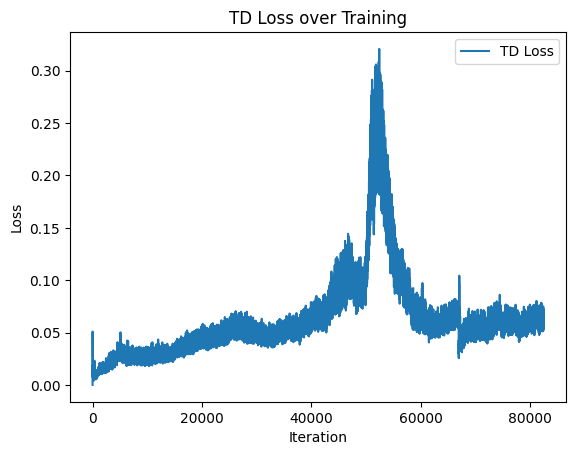

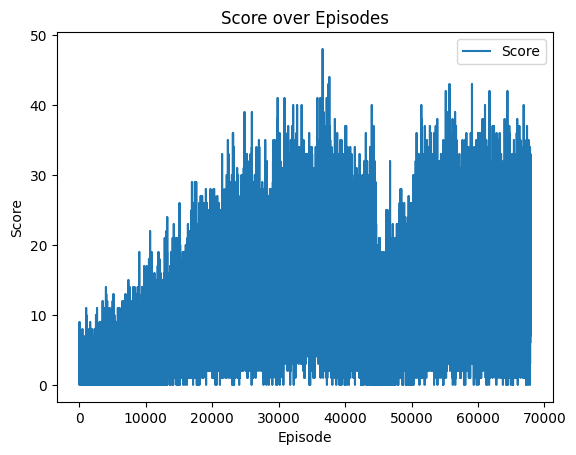

Episode: 971 | Step:  96 / 9050001 | Reward: -1.000 / 8.000 | Loss: 0.092 | Epsilon: 0.100
score: 12.0
Episode: 972 | Step: 175 / 9050176 | Reward: 0.000 / 17.000 | Loss: 0.032 | Epsilon: 0.100
score: 21.0
Episode: 973 | Step: 150 / 9050326 | Reward: 0.000 / 13.000 | Loss: 0.039 | Epsilon: 0.100
score: 17.0
Episode: 974 | Step: 166 / 9050492 | Reward: 0.000 / 17.000 | Loss: 0.054 | Epsilon: 0.100
score: 21.0
Episode: 975 | Step: 133 / 9050625 | Reward: 0.000 / 7.000 | Loss: 0.066 | Epsilon: 0.100
score: 11.0
Episode: 976 | Step: 145 / 9050770 | Reward: -1.000 / 6.000 | Loss: 0.072 | Epsilon: 0.100
score: 11.0
Episode: 977 | Step: 197 / 9050967 | Reward: 0.000 / 17.000 | Loss: 0.040 | Epsilon: 0.100
score: 21.0
Episode: 978 | Step: 175 / 9051142 | Reward: 0.000 / 16.000 | Loss: 0.063 | Epsilon: 0.100
score: 20.0
Episode: 979 | Step: 103 / 9051245 | Reward: 0.000 / 3.000 | Loss: 0.044 | Epsilon: 0.100
score: 7.0
Episode: 980 | Step: 185 / 9051430 | Reward: 0.000 / 16.000 | Loss: 0.046 | 

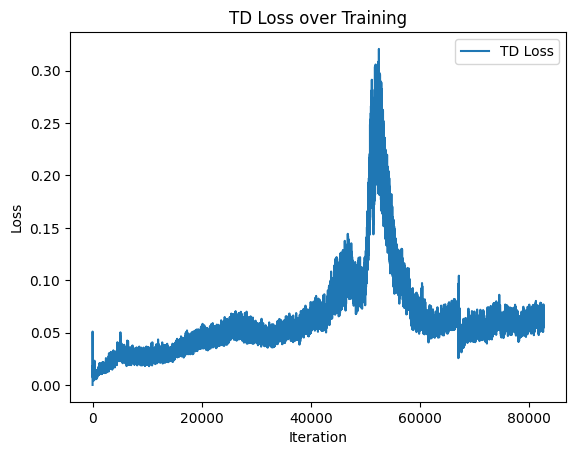

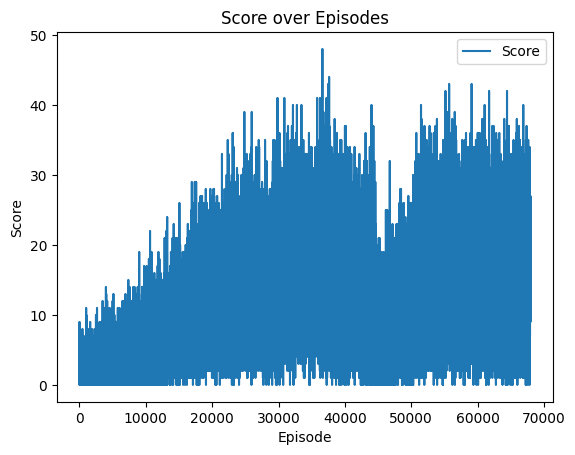

Episode: 1033 | Step:  75 / 9060001 | Reward: -1.000 / 4.000 | Loss: 0.048 | Epsilon: 0.100
score: 7.0
Episode: 1034 | Step: 125 / 9060126 | Reward: 0.000 / 12.000 | Loss: 0.047 | Epsilon: 0.100
score: 16.0
Episode: 1035 | Step: 225 / 9060351 | Reward: -1.000 / 19.000 | Loss: 0.036 | Epsilon: 0.100
score: 24.0
Episode: 1036 | Step: 180 / 9060531 | Reward: 0.000 / 13.000 | Loss: 0.061 | Epsilon: 0.100
score: 17.0
Episode: 1037 | Step: 205 / 9060736 | Reward: 0.000 / 20.000 | Loss: 0.087 | Epsilon: 0.100
score: 24.0
Episode: 1038 | Step:  57 / 9060793 | Reward: 0.000 / -1.000 | Loss: 0.066 | Epsilon: 0.100
score: 3.0
Episode: 1039 | Step: 159 / 9060952 | Reward: -1.000 / 18.000 | Loss: 0.067 | Epsilon: 0.100
score: 23.0
Episode: 1040 | Step: 107 / 9061059 | Reward: 0.000 / 5.000 | Loss: 0.054 | Epsilon: 0.100
score: 9.0
Episode: 1041 | Step: 155 / 9061214 | Reward: 0.000 / 24.000 | Loss: 0.137 | Epsilon: 0.100
score: 28.0
Episode: 1042 | Step: 133 / 9061347 | Reward: 0.000 / 9.000 | Loss

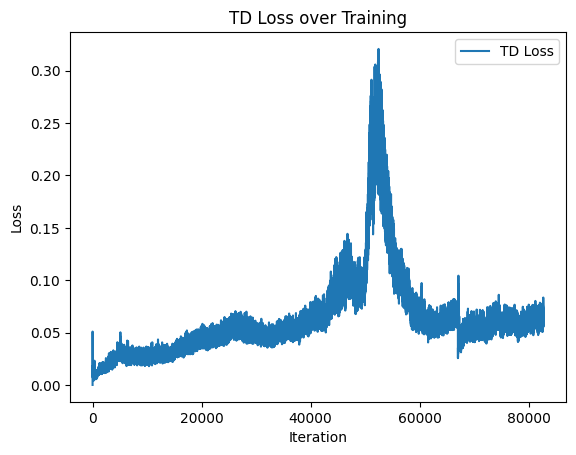

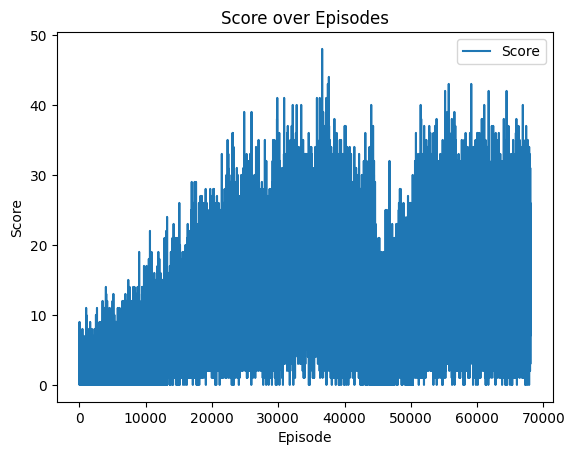

Episode: 1101 | Step:  28 / 9070001 | Reward: -1.000 / 1.000 | Loss: 0.125 | Epsilon: 0.100
score: 2.0
Episode: 1102 | Step: 222 / 9070223 | Reward: 0.000 / 17.000 | Loss: 0.067 | Epsilon: 0.100
score: 21.0
Episode: 1103 | Step: 129 / 9070352 | Reward: -1.000 / 6.000 | Loss: 0.097 | Epsilon: 0.100
score: 11.0
Episode: 1104 | Step: 179 / 9070531 | Reward: 0.000 / 13.000 | Loss: 0.093 | Epsilon: 0.100
score: 17.0
Episode: 1105 | Step: 165 / 9070696 | Reward: 0.000 / 10.000 | Loss: 0.062 | Epsilon: 0.100
score: 14.0
Episode: 1106 | Step: 183 / 9070879 | Reward: 0.000 / 15.000 | Loss: 0.075 | Epsilon: 0.100
score: 19.0
Episode: 1107 | Step: 132 / 9071011 | Reward: 0.000 / 8.000 | Loss: 0.045 | Epsilon: 0.100
score: 12.0
Episode: 1108 | Step: 168 / 9071179 | Reward: 0.000 / 11.000 | Loss: 0.048 | Epsilon: 0.100
score: 15.0
Episode: 1109 | Step: 169 / 9071348 | Reward: -1.000 / 15.000 | Loss: 0.044 | Epsilon: 0.100
score: 20.0
Episode: 1110 | Step: 170 / 9071518 | Reward: 0.000 / 17.000 | Lo

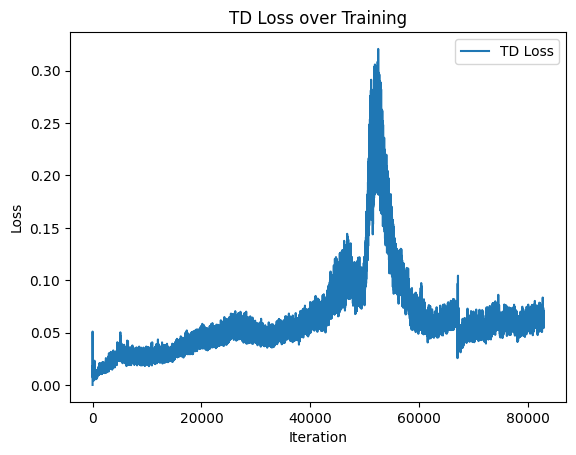

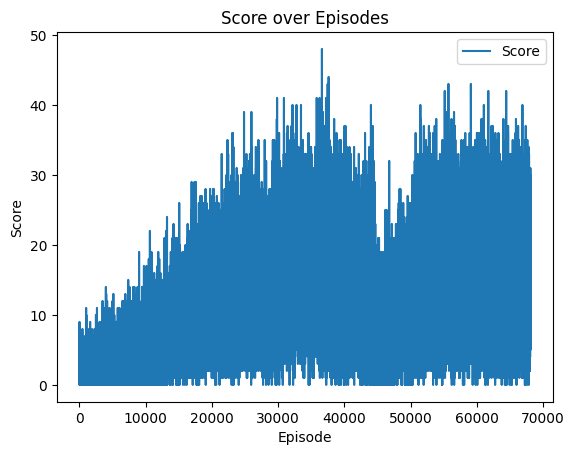

Episode: 1164 | Step:  46 / 9080001 | Reward: -1.000 / -1.000 | Loss: 0.055 | Epsilon: 0.100
score: 0.0
Episode: 1165 | Step: 121 / 9080122 | Reward: -1.000 / 4.000 | Loss: 0.045 | Epsilon: 0.100
score: 9.0
Episode: 1166 | Step: 131 / 9080253 | Reward: -1.000 / 5.000 | Loss: 0.028 | Epsilon: 0.100
score: 10.0
Episode: 1167 | Step:  55 / 9080308 | Reward: -1.000 / -2.000 | Loss: 0.070 | Epsilon: 0.100
score: 3.0
Episode: 1168 | Step: 175 / 9080483 | Reward: -1.000 / 17.000 | Loss: 0.093 | Epsilon: 0.100
score: 22.0
Episode: 1169 | Step: 138 / 9080621 | Reward: 0.000 / 7.000 | Loss: 0.029 | Epsilon: 0.100
score: 11.0
Episode: 1170 | Step: 118 / 9080739 | Reward: 0.000 / 5.000 | Loss: 0.022 | Epsilon: 0.100
score: 9.0
Episode: 1171 | Step: 164 / 9080903 | Reward: -1.000 / 13.000 | Loss: 0.057 | Epsilon: 0.100
score: 18.0
Episode: 1172 | Step: 109 / 9081012 | Reward: 0.000 / 5.000 | Loss: 0.063 | Epsilon: 0.100
score: 9.0
Episode: 1173 | Step: 163 / 9081175 | Reward: -1.000 / 9.000 | Loss:

In [ ]:
train(env_break, agent, stack_frames, img_size, save_path=os.path.join("breakout/gif", "save"), max_steps=10000000) #8.

In [ ]:
def drawing(png_date):
    import os
    import numpy as np
    score_path = os.path.join("breakout/gif/save/"+png_date+"/total_re_"+png_date+".npy")
    score=np.load(score_path)
    num=100
    cnt=len(score)
    cnt-=(cnt%num)
    aver_score=[]

    for i in range(0,cnt,num):
        value=0
        for j in range(i,i+num):
            value+=score[j]
        value/=num
        aver_score.append(value)
    x_t_reward=np.array(list(range(len(aver_score))))
    plt.plot(x_t_reward,aver_score, label='Score') ####
    plt.xlabel('Episode') ####
    plt.ylabel('Score')
    plt.title('Score over Episodes')
    plt.legend()
    plt.savefig("breakout/gif/png/"+png_date+".png")
    plt.show()

In [ ]:
drawing("50303")

In [ ]:
agent.save_load_model(op="save", path=os.path.join("breakout/gif/save"), fname="qnet_"+date_new+".pt")
agent.save_load_model(op="load", path="breakout/gif/save/", fname="qnet_"+date_new+".pt") #3.
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, "eval_"+date_new+".gif",os.path.join("breakout/gif/eval"))

In [ ]:
agent.plot_loss()

In [ ]:
agent.plot_rewards()

In [ ]:
agent.plot_t_r()

#補跑eval

In [ ]:
agent.save_load_model(op="load", path="/content/drive/MyDrive/gif/save", fname="qnet_32502.pt") #3.
img_buffer = play(env_break, agent, stack_frames, img_size)
save_gif(img_buffer, "eval_32502.gif",os.path.join("/content/drive/MyDrive/gif/eval"))  #, "eval") #10.

float64
Step: 180 | Reward: 0.000 / 40.000
